# Analiza napovedovanja vremena
Projekt pri predmetu Programiranje 1, Fakulteta za matematiko in fiziko.
Analizirali bomo točnost napovedovanja vremena, ko se bližamo dnevu, ki ga opazujemo. Primerjali bomo različne strani (in modele) napovedovanja vremena. Pogledali bomo kateri podatki odstopajo absolutno največ in kateri v povprečju največ.
Podatki so zajeti iz:
* Arhiva ARSO, to so izmerjeni podatki ARSO-ve atomatske vremenske postaje
* Geopedie, ki uporablja računsko napoved FMF
* Accuweather, ki omogoča napoved za 4 dni naprej
* Wunderground, ki omogoča napoved za 10 dni naprej

Vse vrednosti za temperaturo so v stopinjah celzija [°C], vlažnost pa je relativna [%].
Napovedi so izdelane za Planino pod Golico (954 m n.m.v.), kjer je samodejna meteorološka postaja tudi izmerila podatke.
## Priprava
Najprej uvozimo knjižnice za delo s podatki in uvozimo podatke iz csv datotek. Napovedi za določeno število dni naprej so ločene po CSV datotekah, kot so tudi različne spletne strani.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Graf med besedilom.
%matplotlib inline

# Nastavitev števila vrstic podatkov.
pd.options.display.max_rows = 20

# Uvoz podatkov.
izmerjeni_podatki = pd.read_csv('csv/izmerjeni_podatki.csv', index_col='cas')
fmf_danes = pd.read_csv('csv/fmf_danes.csv', index_col='cas')
fmf_jutri = pd.read_csv('csv/fmf_jutri.csv', index_col='cas')
accu_1 = pd.read_csv('csv/accu_dan_1.csv', index_col='cas')
accu_2 = pd.read_csv('csv/accu_dan_2.csv', index_col='cas')
accu_3 = pd.read_csv('csv/accu_dan_3.csv', index_col='cas')
accu_4 = pd.read_csv('csv/accu_dan_4.csv', index_col='cas')
wunder_0 = pd.read_csv('csv/wunder_dan_0.csv', index_col='cas')
wunder_1 = pd.read_csv('csv/wunder_dan_1.csv', index_col='cas')
wunder_2 = pd.read_csv('csv/wunder_dan_2.csv', index_col='cas')
wunder_3 = pd.read_csv('csv/wunder_dan_3.csv', index_col='cas')
wunder_4 = pd.read_csv('csv/wunder_dan_4.csv', index_col='cas')
wunder_5 = pd.read_csv('csv/wunder_dan_5.csv', index_col='cas')
wunder_6 = pd.read_csv('csv/wunder_dan_6.csv', index_col='cas')
wunder_7 = pd.read_csv('csv/wunder_dan_7.csv', index_col='cas')
wunder_8 = pd.read_csv('csv/wunder_dan_8.csv', index_col='cas')
wunder_9 = pd.read_csv('csv/wunder_dan_9.csv', index_col='cas')

Podatki so bili zajeti vsak dan okoli 00:00 s pomočjo skript, ki so dostopne na GitHub-u in shranjeni v CSV datoteko. Ponekod niso popolni, saj nekatere spletne strani ne napovedujejo vremena za vse ure dneva.
Večina podatkov vsebuje čas zajetja: `cas`, ki je tudi indeksni stolpec, ter podatka `temperatua` in `vlaga`.

## Primerjava točnosti napovedovanja različnih strani

In [2]:
izmerjeni_podatki

,temperatura,vlaznost
cas,,
08.02.2016 0:00,2.6,95
08.02.2016 1:00,2.5,97
08.02.2016 2:00,2.3,97
08.02.2016 3:00,2.4,98
08.02.2016 4:00,2.4,98
08.02.2016 5:00,2.5,98
08.02.2016 6:00,2.9,98
08.02.2016 7:00,2.7,98
08.02.2016 8:00,3.1,99


### Koliko največ odstopajo podatki pri napovedi za isti dan iz različnih virov?
Najprej ustvarimo tabele za analizo in dodamo stolpce `razlika`, ki vsebujejo podatke o razliki med izmerjeno in napovedano vrednostjo.

In [2]:
# Izmerjenim podatkom dodamo podatke iz Geopedie za tekoči dan
analiza_fmf_0 = pd.merge(izmerjeni_podatki[['temperatura']], fmf_danes, left_index=True, right_index=True,
                                 suffixes=('_izmerjeno', '_fmf'))
analiza_fmf_0['razlika'] = analiza_fmf_0.temperatura_fmf - analiza_fmf_0.temperatura_izmerjeno

# Izmerjenim podatkom dodamo podatke iz AccuWeather za tekoči dan
analiza_accu_0 = pd.merge(izmerjeni_podatki, accu_1, left_index=True, right_index=True,
                                      suffixes=('_izmerjeno', '_accuweather'))
analiza_accu_0['razlika_t'] = analiza_accu_0.temperatura_accuweather - analiza_accu_0.temperatura_izmerjeno
analiza_accu_0['razlika_v'] = analiza_accu_0.vlaznost_accuweather - analiza_accu_0.vlaznost_izmerjeno

# Izmerjenim podatkom dodamo podatke iz Wunderground za tekoči dan
analiza_wunder_0 = pd.merge(izmerjeni_podatki, wunder_0, left_index=True, right_index=True,
                            suffixes=('_izmerjeno', '_wunderground'))
analiza_wunder_0['razlika_t'] = analiza_wunder_0.temperatura_wunderground - analiza_wunder_0.temperatura_izmerjeno
analiza_wunder_0['razlika_v'] = analiza_wunder_0.vlaznost_wunderground - analiza_wunder_0.vlaznost_izmerjeno

#### Tabela za primerjavo različnih strani
V tabeli so prikazani podatki o točnosti napovedi za tekoči dan (napoved ob 00:00)

In [3]:
geo_t_max = max(abs(analiza_fmf_0['razlika']))
geo_t_avg = analiza_fmf_0['razlika'].apply(abs).mean()

accu_t_max = max(abs(analiza_accu_0['razlika_t']))
accu_t_avg = analiza_accu_0['razlika_t'].apply(abs).mean()
accu_v_max = max(abs(analiza_accu_0['razlika_v']))
accu_v_avg = analiza_accu_0['razlika_v'].apply(abs).mean()

wunder_t_max = max(abs(analiza_wunder_0['razlika_t']))
wunder_t_avg = analiza_wunder_0['razlika_t'].apply(abs).mean()
wunder_v_max = max(abs(analiza_wunder_0['razlika_v']))
wunder_v_avg = analiza_wunder_0['razlika_v'].apply(abs).mean()

primerjava = {'Geopedia': [geo_t_max, geo_t_avg, 'NaN', 'NaN'],
              'AccuWeather': [accu_t_max, accu_t_avg, accu_v_max, accu_v_avg],
              'Wunderground': [wunder_t_max, wunder_t_avg, wunder_v_max, wunder_v_avg]}

tabela_razlik_0 = pd.DataFrame(data=primerjava, index = ['Največja napaka temperature', 'Povprečna napaka temperature', 
                                            'Največja napaka vlage', 'Povprečna napaka vlage'])
tabela_razlik_0

,AccuWeather,Geopedia,Wunderground
Največja napaka temperature,7.800000,4.7,5.600000
Povprečna napaka temperature,2.971579,1.52752,2.453846
Največja napaka vlage,30.000000,NaN,35.000000
Povprečna napaka vlage,8.733333,NaN,12.076923


Spodnji trije grafi ponazarjajo razliko med izmerjeno in napovedano temperaturo v odvisnosti od časa.

**Geopedia**

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


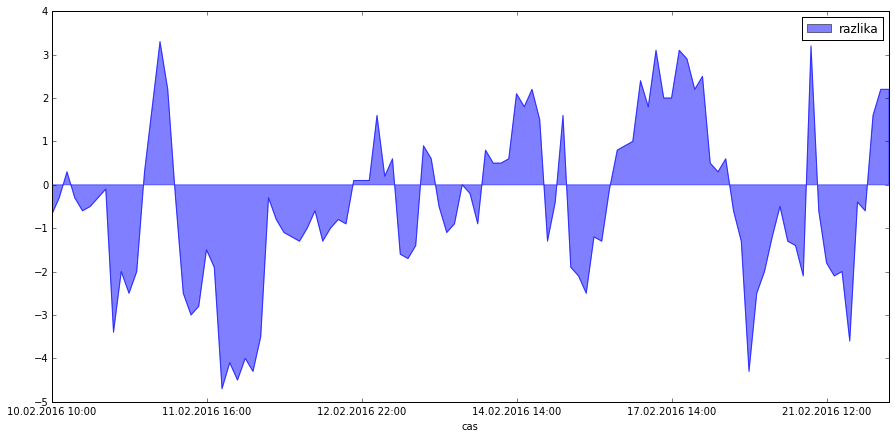

In [14]:
analiza_fmf_0[['razlika']].plot(kind='area', figsize=(15,7), stacked=False)

**AccuWeather**

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


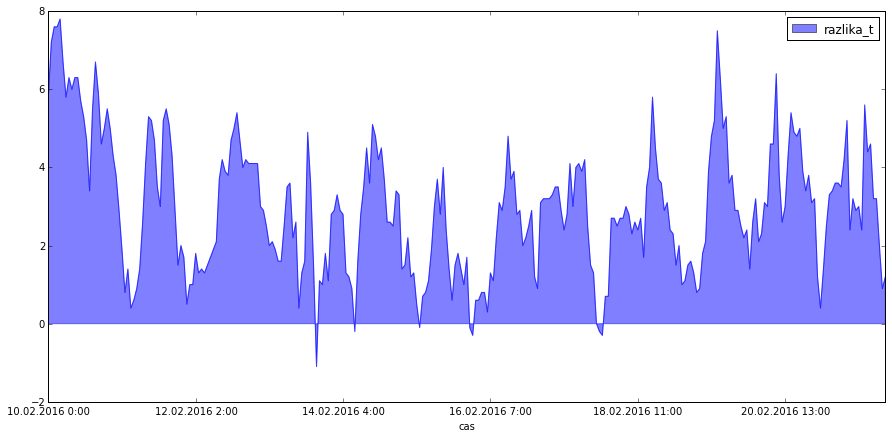

In [15]:
analiza_accu_0[['razlika_t']].plot(kind='area', figsize=(15,7), stacked=False)

**Wunderground**

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


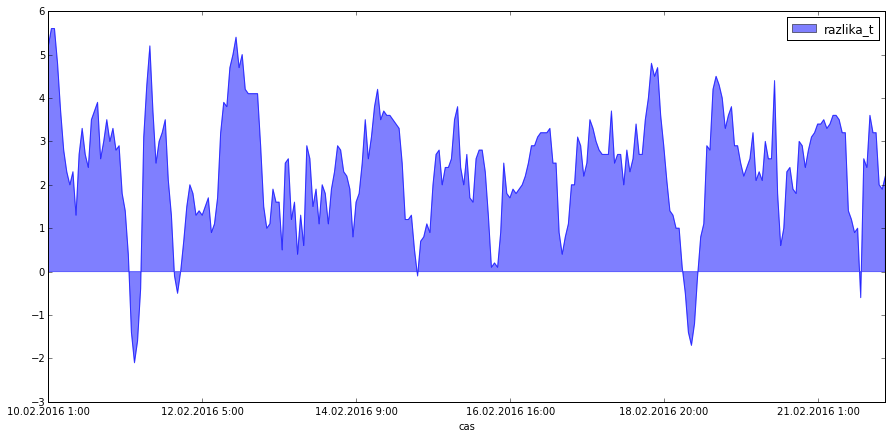

In [16]:
analiza_wunder_0[['razlika_t']].plot(kind='area', figsize=(15,7), stacked=False)

Opazimo, da ima `Geopedia` najnatančnejšo napoved temperature za tekoči dan. Razlika med izmerjeno in napovedano temperaturo niha okrog 0 in ni večino časa pozirivna (kot v primeru `AccuWeather` in `Wunderground`). Iz podatkov podatkov slednjih lahko ugibamo, da je bila napoved narejena za nižje ležeči kraj, čeprav je bil kraj pravilno izbran. Več o primerjavi točnosti napovedovanja vremena bi lahko izvedeli, če bi opazovali npr. Ljubljano, saj je verjetno napoved točnejša. Če si ogledamo še graf izmerjene in napovedane temperature za `Geopedio` vidimo, da je napoved dokaj točna.

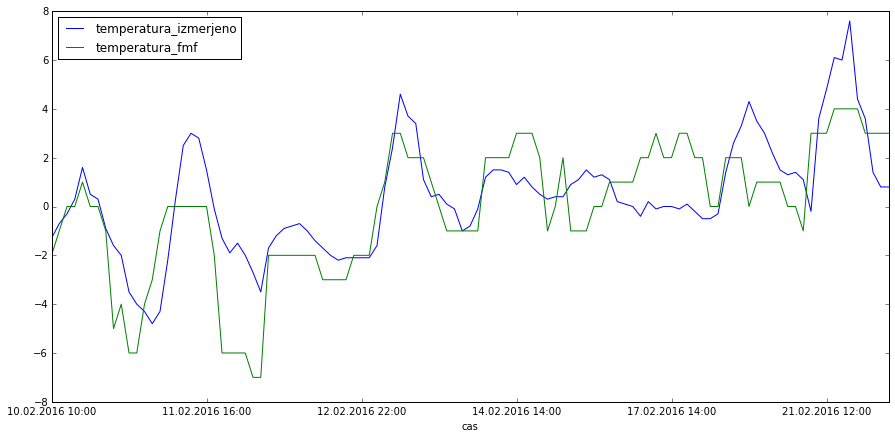

In [17]:
analiza_fmf_0[['temperatura_izmerjeno', 'temperatura_fmf']].plot(figsize=(15,7))

Pri `AccuWeather` in `Wunderground` pa se vsaj ujema čas maximumov in minimumov. Za primer si oglejmo graf izmerjene in napovedane temperature strani `Wunderground`.

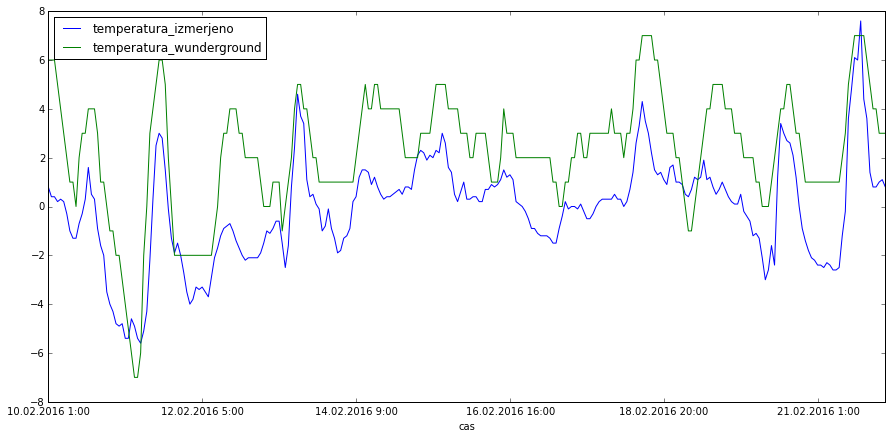

In [18]:
analiza_wunder_0[['temperatura_izmerjeno', 'temperatura_wunderground']].plot(figsize=(15,7))

## Spreminjanje točnosti napovedovanja vremena
### AccuWeather
Za `AccuWeather` si oglejmo le graf, ki prikazuje spreminjanje napovedane temperature in vlage različnih dni in izmerjene.